In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1

from bins import Bins
from utils import calcAllChi2, calcOneChi2, HistMaker, diffHist
from ROOT import TFile, TH1, TH3F, TCanvas, TStyle, gStyle, Form
import math

Welcome to JupyROOT 6.28/04


In [2]:
bins = Bins.readFrom("ranges.yml")
histMakerData = HistMaker("088_090_ag123ag_2500A_accepted_np.dat", "_data", bins)
#histsData = histMakerData.makeHists()
histsData = histMakerData.makeHists()
#histMakerMC = HistMaker("medium_isotropic_eff_ag1230ag_np_9deg.dat", "_MC", bins    )
histMakerMC_rho = HistMaker("mar19_diele_inmedium_heli0cm_np.dat", "_MC", bins    )
histMakerMC_pi0 = HistMaker("mar19_diele_pi0_heli0cm_np.dat", "_MC", bins    )



iter 0
Before processing events 10:33:03
After processing events 10:33:07
iter 1
Before processing events 10:33:22
After processing events 10:33:23
iter 2
Before processing events 10:33:29
After processing events 10:33:29


Warning in <TROOT::Append>: Replacing existing TH1: hmass_MC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz_MC (Potential memory leak).


Info in <TCanvas::Print>: gif file base_hists_pi0_MC.gif has been created


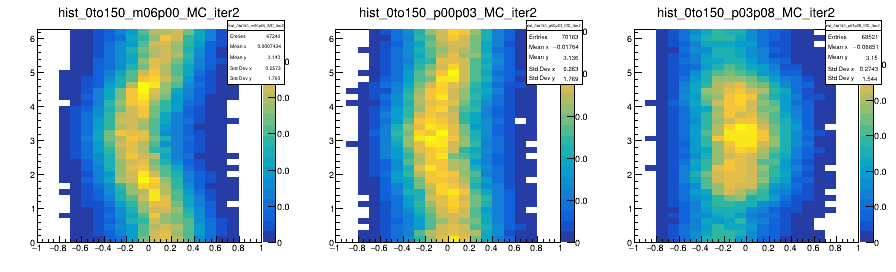

In [3]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        can3.cd(i+1)
        if not isinstance(hist, list):
            hist.Draw("COLZ")
        else:
            print(hist)
can3.SaveAs("base_hists_pi0_MC.gif")


Info in <TCanvas::Print>: gif file base_hists_rho_MC.gif has been created


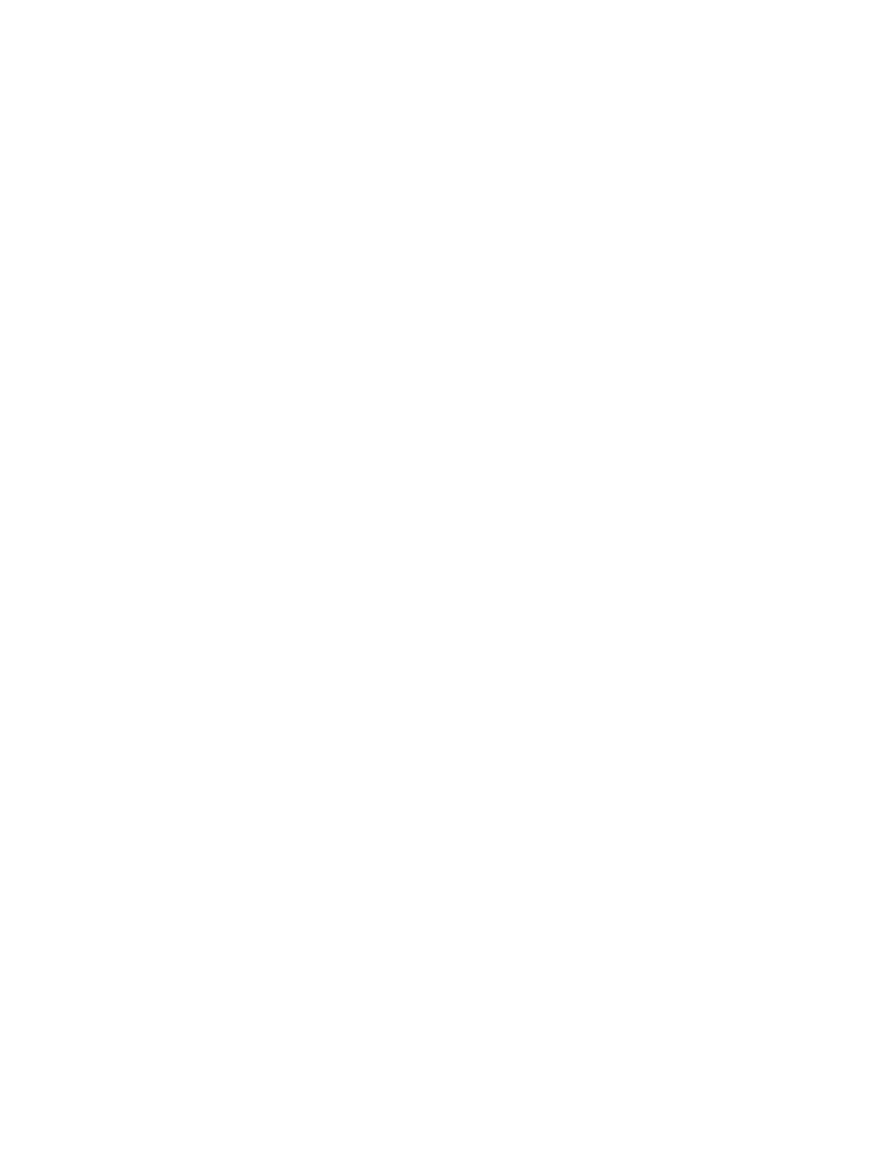

In [4]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    can3.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)
can3.SaveAs("base_hists_rho_MC.gif")


Info in <TCanvas::Print>: gif file histsData.gif has been created


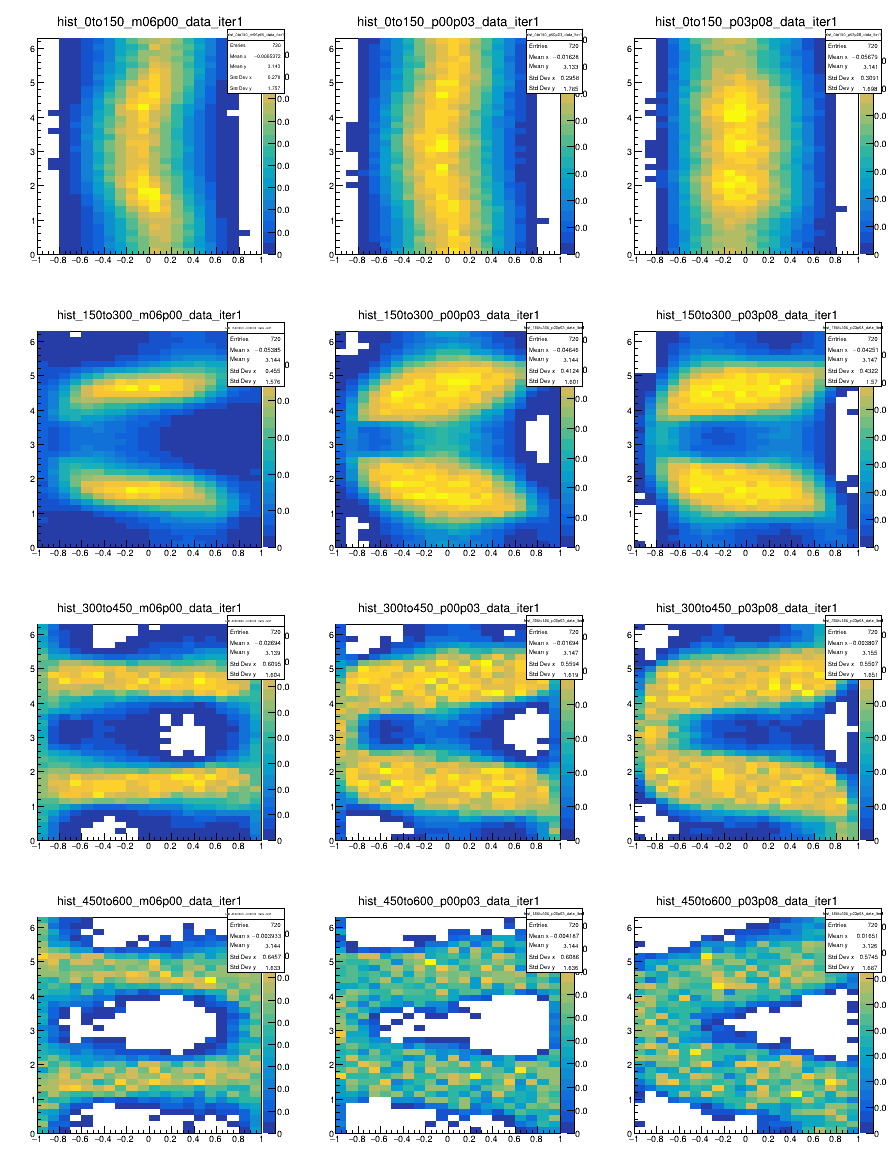

In [5]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)

can4.SaveAs("histsData.gif")

In [6]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [7]:
TH1.SetDefaultSumw2

N_PARAMS = 3

In [8]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[0, 0,         0],
                       [1, 2*math.pi, 2]], dtype=torch.float)
bounds = bounds.to(mps_device)


grid_r   = torch.linspace(bounds[0][0], bounds[1][0], 101)
grid_phi = torch.linspace(bounds[0][1], bounds[1][1], 101)
grid_z   = torch.linspace(bounds[0][2], bounds[1][2], 101)

grid_x1, grid_x2, grid_x3 = torch.meshgrid(grid_r, grid_phi, grid_z, indexing="ij")

xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten(), grid_x3.flatten()]).transpose(-2,-1)

In [9]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [10]:
num_queries = 175
num_repeats = 1
num_samples = 1

In [11]:
def lambdas(xx):
   # return x[0], x[1], x[2]
    r, phi, z = xx[0], xx[1], xx[2]
    x = r*math.cos(phi)
    y = r*math.sin(phi)
    lambda_theta = 0.5 * (2*x + z)
    lambda_phi   = 0.25 * (-2 - 2*x + 3*z)
    lambda_theta_phi = y/math.sqrt(2.)
    return lambda_theta, lambda_phi, lambda_theta_phi

def all_lambdas(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)
            yield torch.tensor([lambda_theta, lambda_phi, lambda_theta_phi])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])

In [12]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_titles = [r"R of cone coordinates", r"$\Phi$ of cone coordinates", r"Z of cone coordinates"]

def oneplot(ax, tensor, index, cmap, title, transpose=None):
        
        global xs
        tensor_3d = torch.reshape(tensor, (101,101,101))
        xs_3d = torch.reshape(xs, (101,101,101,3))
        if transpose:
               tensor_3d = tensor_3d.transpose(transpose[0],transpose[1])
               xs_3d     = xs_3d    .transpose(transpose[0],transpose[1])
        if transpose is None:
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        elif transpose == (0,1):
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][0],
                        xs_3d[0][-1][0][0],
                ]
        elif transpose == (0,2):
                extent=[
                        xs_3d[0][0][0][0],
                        xs_3d[0][0][-1][0],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        if transpose is None:
                x_title=axis_titles[2]
                y_title=axis_titles[1]
        elif transpose == (0, 1):
                x_title=axis_titles[2]
                y_title=axis_titles[0]
        elif transpose == (0,2):
                x_title=axis_titles[0]
                y_title=axis_titles[1]
        
        pos = ax.imshow(tensor_3d[index], cmap=cmap, interpolation="nearest", origin="lower", 
                vmin=0, vmax=tensor.max(), extent=extent)
        ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        plt.colorbar(pos,fraction=0.046, pad=0.04)

def ff(x, transpose, scale):
        cmap = "gist_rainbow"
        index = int(x*100/scale)
        fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
        oneplot(ax, predictive_mean, index, cmap, r"ndf$/\chi^2$", transpose)
       # oneplot(ax[1], predictive_upper-predictive_lower, index, cmap, "confidence int. width", transpose)
       # oneplot(ax[1], acquisition_score, index, cmap, "acquisition score", transpose)
        
        return ax

def f(x):
        return ff(x, None, 1.0)
        
def g(x):
        return ff(x, (0,1),2*math.pi)

def h(x):
        return ff(x, (0,2), 2.0)

gStyle.SetOptStat(0)

def plotComparison(histMC, histData):
    can = TCanvas("can","can",600,600)
    can.Divide(2,2)
    can.Draw()
    can.cd(1)
    histMC.Draw("COLZ")
    can.cd(2)
    histData.Draw("COLZ")
    pad = can.cd(3)
    pad.SetRightMargin(0.155)
    pad = can.cd(3)
    hdiff = diffHist(histMC, histData)
    hdiff.Draw("COLZ")
    can.Update()
    palette = hdiff.GetListOfFunctions().FindObject("palette")
    palette.SetX1NDC(0.85)
    palette.SetX2NDC(0.9)
    can.Modified()
    can.Update()
    can.cd(4)
    nby = histMC.GetNbinsX()
    py = histMC.ProjectionY("py",1,nby)
    py.Draw("HIST")
    return can, hdiff, py

In [13]:
# -2 is the default value when no feasible has been found
default_value = 0

def fit_bo(HIST_INDEX = 0):
    global bounds

    histMakerMC = histMakerMC_pi0 if HIST_INDEX < 3 else histMakerMC_rho

    def objective(xx):
        def generator(xx):
            for x in xx:
                lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)

                histsMC = histMakerMC.makeHists(lambda_theta, lambda_phi, lambda_theta_phi)
                chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData[0][HIST_INDEX])
                allHistsMC.append(histsMC[0][HIST_INDEX])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    for trial in range(num_repeats):
        print("trial", trial)

        torch.manual_seed(trial)
        train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
            train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        print(train_x)
        print(train_x.shape)
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for i in tqdm(range(num_queries)):
            feasible_incumbents[trial, i] = train_utility.max()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                    inequality_constraints=[(torch.tensor([0,2],device=mps_device),torch.tensor([-2.0,-1.0],dtype=torch.float,device=mps_device),-2.0)],
                )

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"./incumbents_" + str(HIST_INDEX) + ".pth")
    fout = TFile("out_"+str(HIST_INDEX)+".root","RECREATE")
    fout.cd()
    for hist in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        hist.Write()
    for j, hists in enumerate(histsData):
        for k, hist in enumerate(hists):
                hist.Write()
               # print ("Writing hist: ", j, k, hist)
    fout.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_lower, predictive_upper = predictive_distribution.confidence_region()
        acquisition_score = policy(xs.unsqueeze(1))

    lds = all_lambdas(train_x)
    lambda_thetas     = lds.transpose(-2,-1)[0]
    lambda_phis       = lds.transpose(-2,-1)[1]
    lambda_theta_phis = lds.transpose(-2,-1)[2]
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        lambda_phis[0:num_queries],
        lambda_theta_phis[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, 4].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_mean

In [14]:

def convert_to_h3d(predictive_mean, HIST_INDEX):
    pm = predictive_mean.reshape(101,101,101)
    pm_min = pm.min()
    print(pm[100][100][100].item())
    hpm = TH3F("hpm","predictive mean", 101, 0, 1, 101, 0, 2*math.pi, 101, 0, 2)
    for binx in range(1,101):
        for biny in range(1,101):
            for binz in range(1,101):
                if pm_min < 0:
                    hpm.SetBinContent(binx,biny,binz,pm[binx][biny][binz].item()-pm_min)
                else:
                    hpm.SetBinContent(binx,biny,binz,pm[binx][biny][binz].item())
    hpm.SaveAs("pm_" + str(HIST_INDEX) + ".root")


In [15]:
def covariance_random_sampling(predictive_mean, HIST_INDEX):
    hpm = convert_to_h3d((predictive_mean, HIST_INDEX))

    from ctypes import c_double
    rnd_points = []

    x = c_double(0.0)
    y = c_double(0.0)
    z = c_double(0.0)
    for i in range(80_000_000):
        if i % 10000000 == 0:
            print(i)
        hpm.GetRandom3(x,y,z)
        rnd_points.append([x.value,y.value,z.value])

    print(x.value,y.value,z.value)
    covariance = np.cov(rnd_points, rowvar=False)
    return covariance

In [16]:
def covariance_weight(predictive_mean):
    predictive_mean_2 = predictive_mean - predictive_mean.min()

    covariance_2 = np.cov(xs, rowvar=False, aweights=predictive_mean_2)
    np.sqrt(covariance_2)

    return covariance_2

trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 0.8480,  0.0129, -0.3774])
covariance matrix: 
 [[ 0.27043674  0.04727995 -0.00416237]
 [ 0.04727995  0.1735169  -0.00697429]
 [-0.00416237 -0.00697429  0.07981767]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 0.9457, -0.0025, -0.1624])
covariance matrix: 
 [[ 0.27685079  0.04389423 -0.01153123]
 [ 0.04389423  0.15958793 -0.0103894 ]
 [-0.01153123 -0.0103894   0.07532283]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 1.0000e+00, -5.5592e-02,  1.3196e-13])
covariance matrix: 
 [[0.25715008 0.03984147 0.00063182]
 [0.03984147 0.18603032 0.00052647]
 [0.00063182 0.00052647 0.07558394]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 2.5299e-01, -1.2052e-01, -1.6460e-08])
covariance matrix: 
 [[0.23531528 0.03862838 0.00464459]
 [0.03862838 0.18159124 0.00575351]
 [0.00464459 0.00575351 0.07801063]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([0.1695, 0.0074, 0.1620])
covariance matrix: 
 [[ 0.24500114  0.04820775 -0.00517468]
 [ 0.04820775  0.1958806  -0.00591187]
 [-0.00517468 -0.00591187  0.07368113]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([0.1662, 0.1850, 0.0976])
covariance matrix: 
 [[ 0.22117531  0.02368868 -0.00364189]
 [ 0.02368868  0.18780323 -0.00240225]
 [-0.00364189 -0.00240225  0.07088123]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

/var/folders/96/myz9b61s4gx36c78ytymzp9h0000gn/T/ipykernel_84022/1038772644.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)


Final result:
lambdas =  tensor([ 0.3526, -0.2781,  0.0392])
covariance matrix: 
 [[0.22107384 0.02610185 0.0043233 ]
 [0.02610185 0.19912052 0.00870988]
 [0.0043233  0.00870988 0.07210263]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 0.1807, -0.1416,  0.2240])
covariance matrix: 
 [[ 0.22351478  0.02665171 -0.01102849]
 [ 0.02665171  0.20050447 -0.00928002]
 [-0.01102849 -0.00928002  0.07539979]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 2.8361e-01, -7.4581e-02,  2.9463e-10])
covariance matrix: 
 [[ 0.22088847  0.02559126 -0.00723282]
 [ 0.02559126  0.20417802 -0.00696006]
 [-0.00723282 -0.00696006  0.07486263]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 0.8613, -0.8385, -0.1575])
covariance matrix: 
 [[ 0.22467961  0.03863364  0.00044243]
 [ 0.03863364  0.1932516  -0.00097263]
 [ 0.00044243 -0.00097263  0.0792959 ]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 0.5839, -0.7919,  0.3758])
covariance matrix: 
 [[ 0.2324581   0.03797293  0.00272301]
 [ 0.03797293  0.18849551 -0.0007099 ]
 [ 0.00272301 -0.0007099   0.07885025]]
trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/175 [00:00<?, ?it/s]

Final result:
lambdas =  tensor([ 0.1190, -0.5595,  0.3639])
covariance matrix: 
 [[ 0.22208408  0.01974629 -0.00241308]
 [ 0.01974629  0.18545584 -0.00383694]
 [-0.00241308 -0.00383694  0.07844055]]


Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing exist

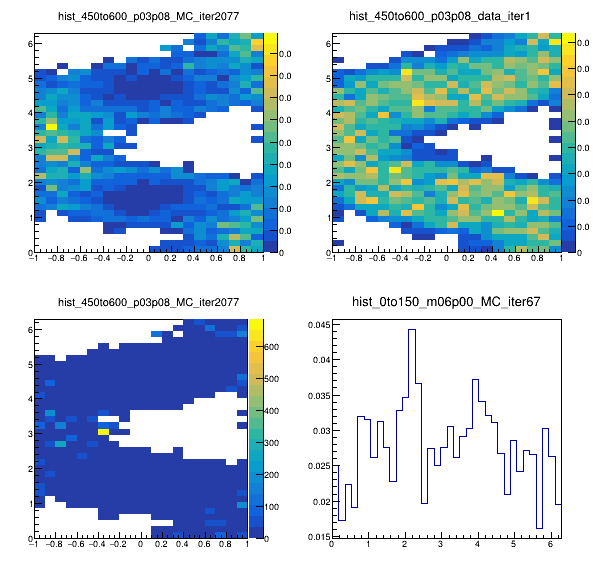

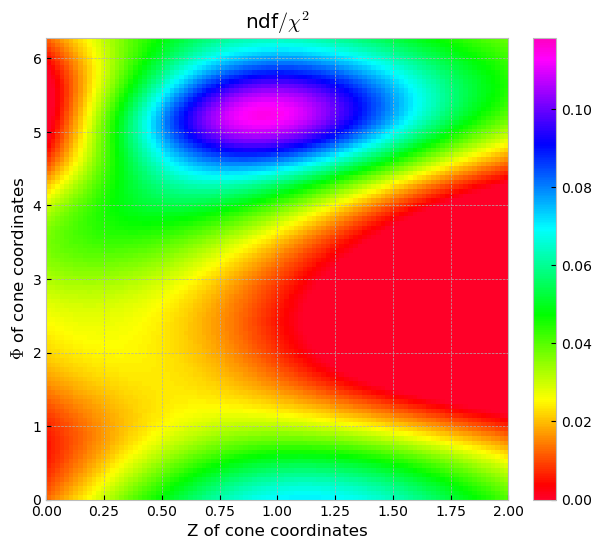

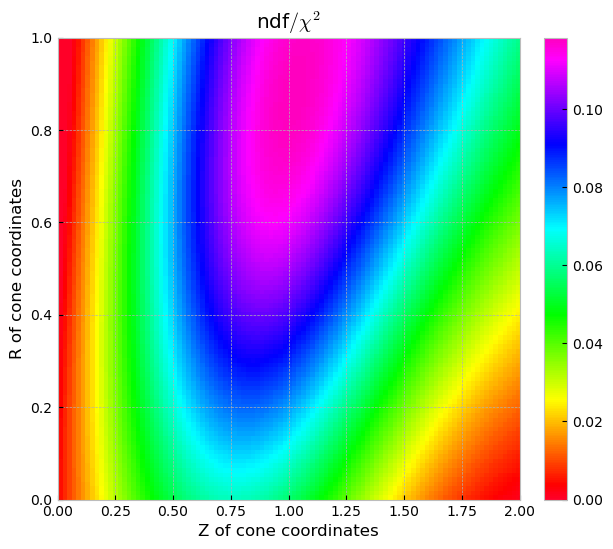

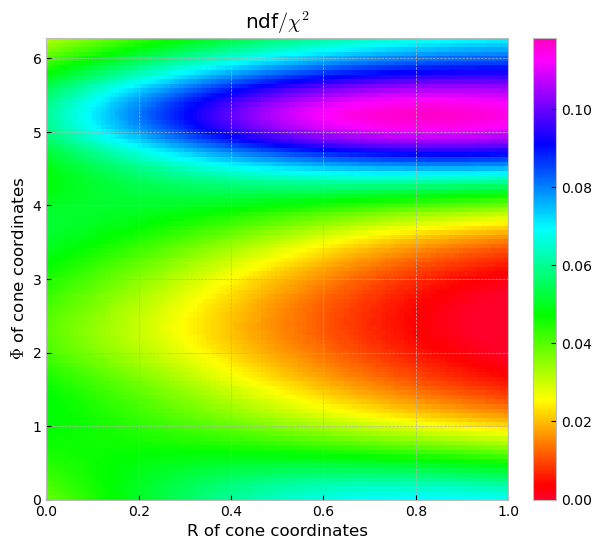

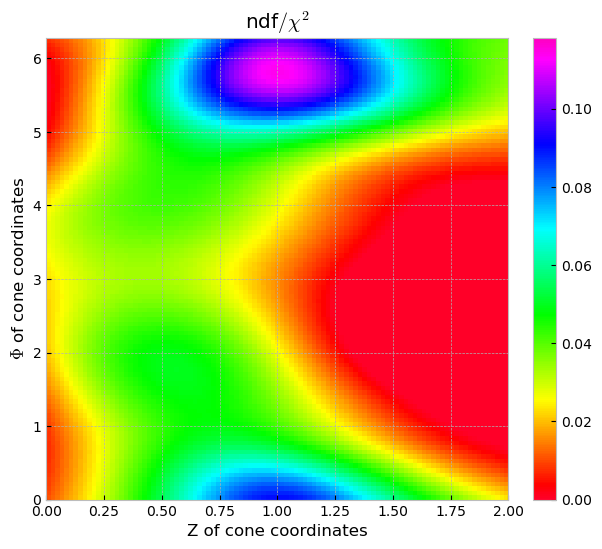

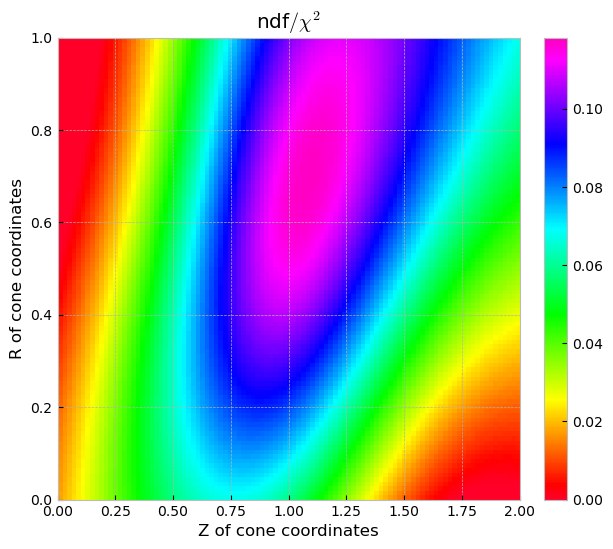

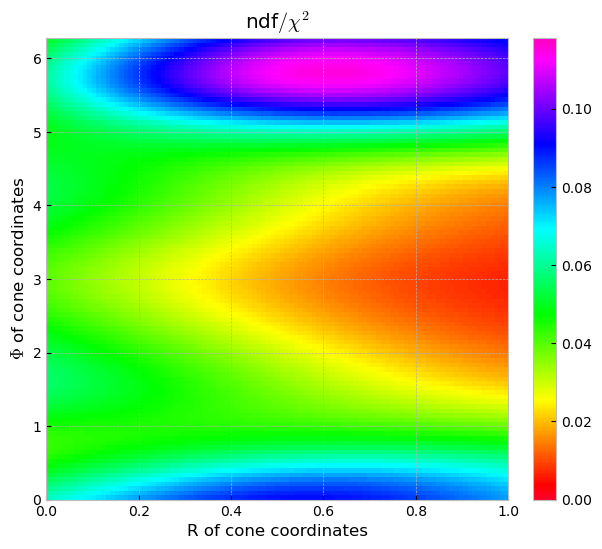

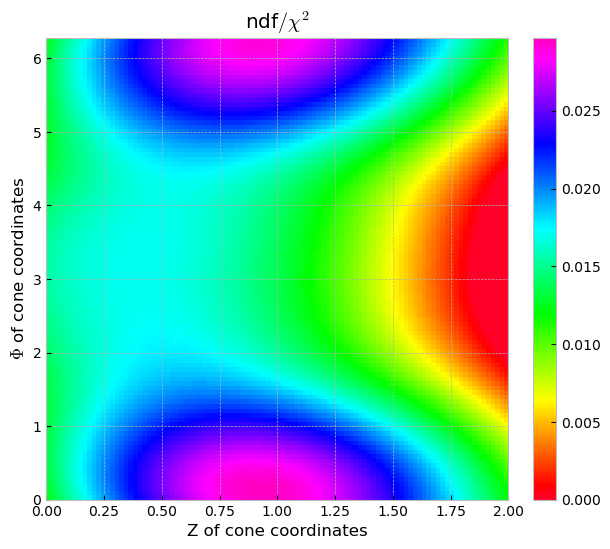

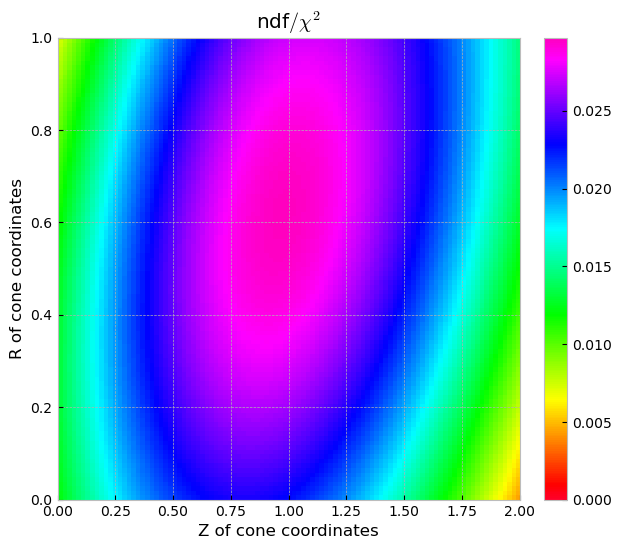

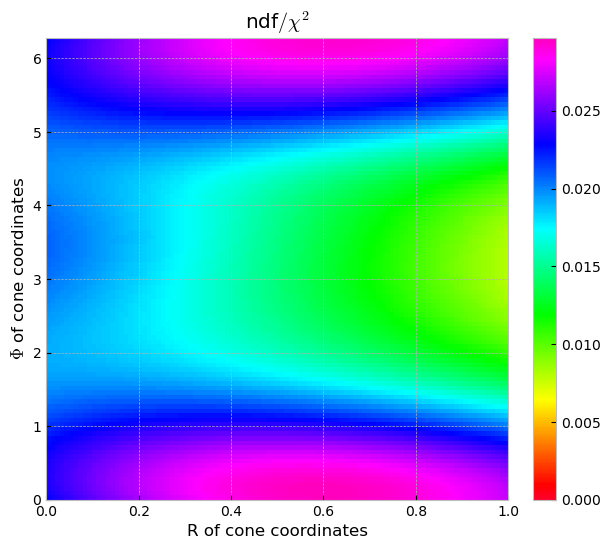

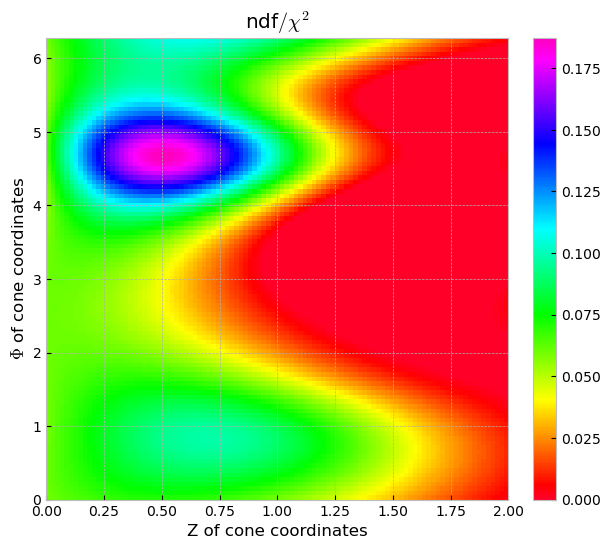

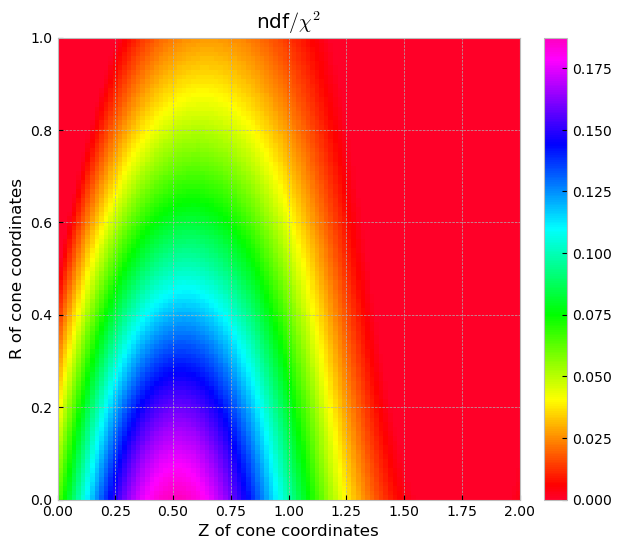

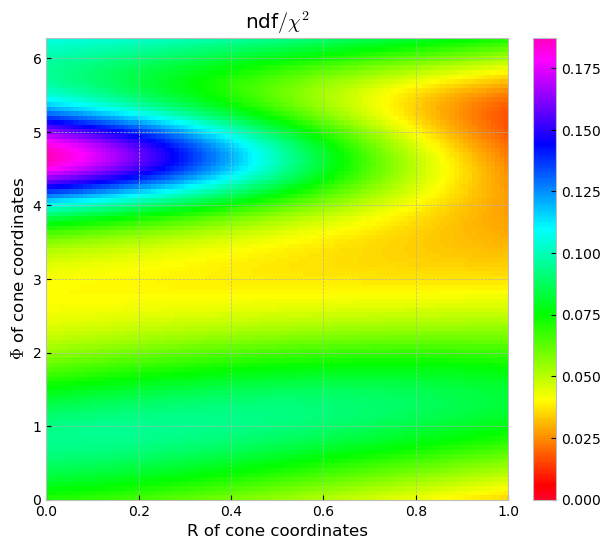

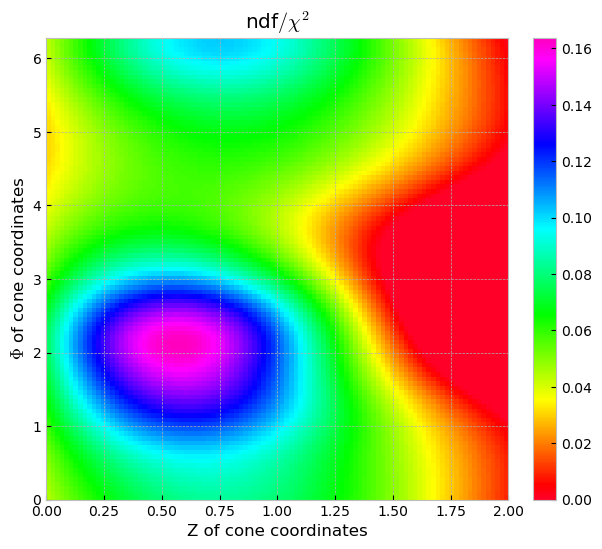

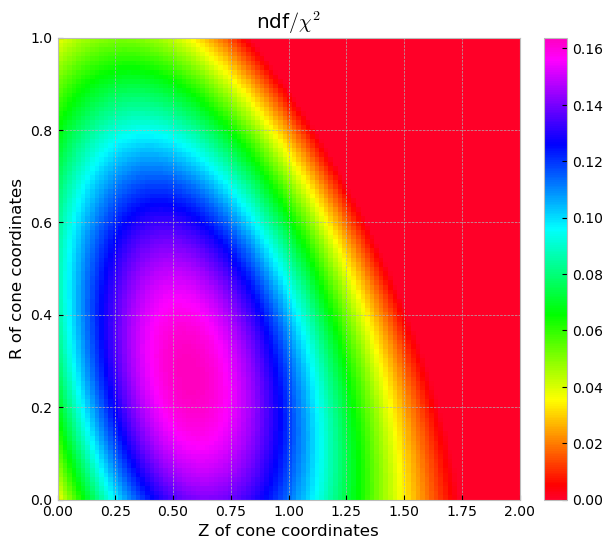

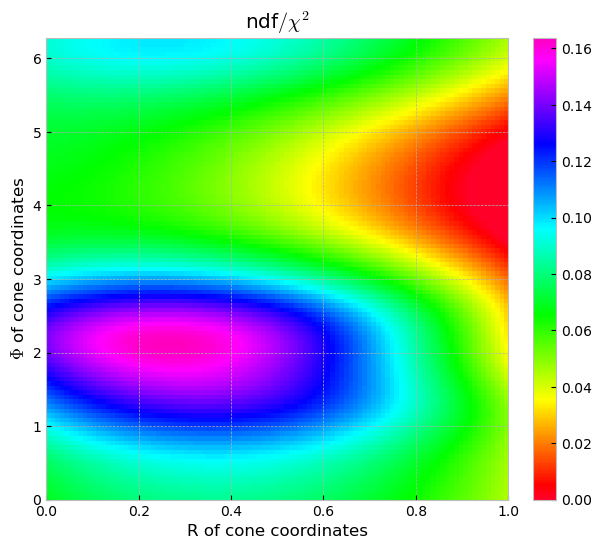

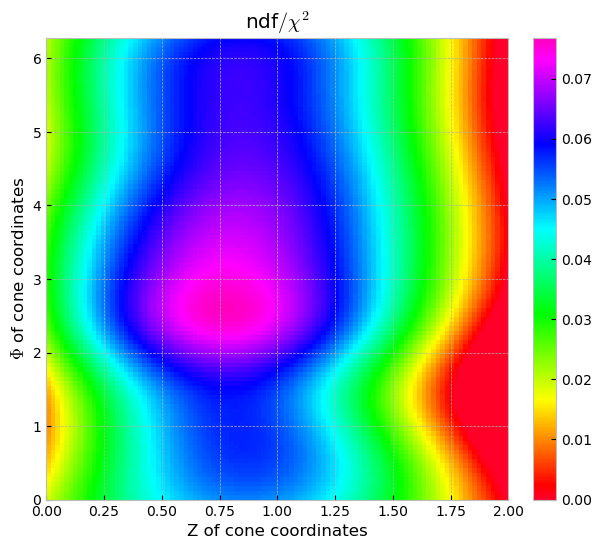

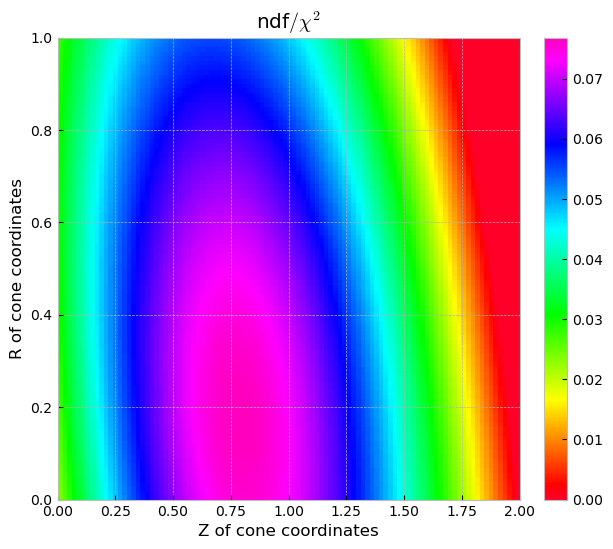

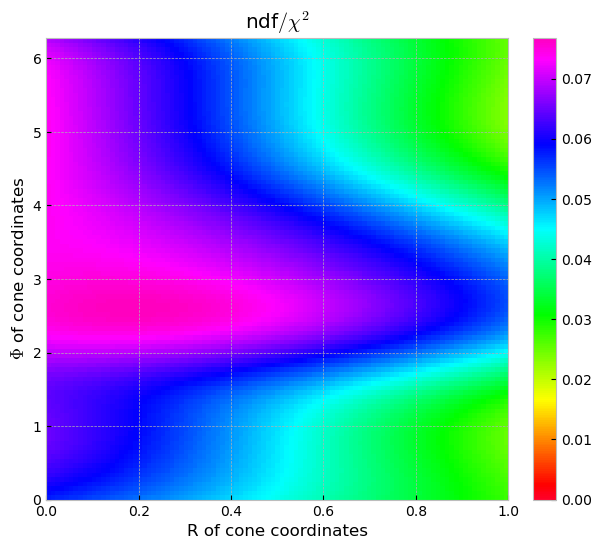

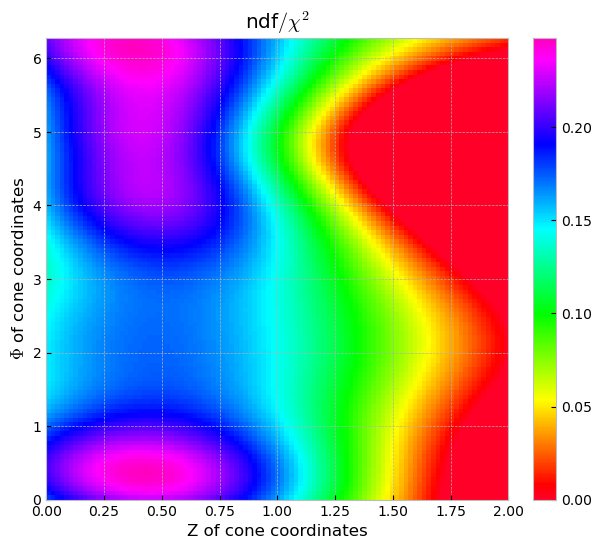

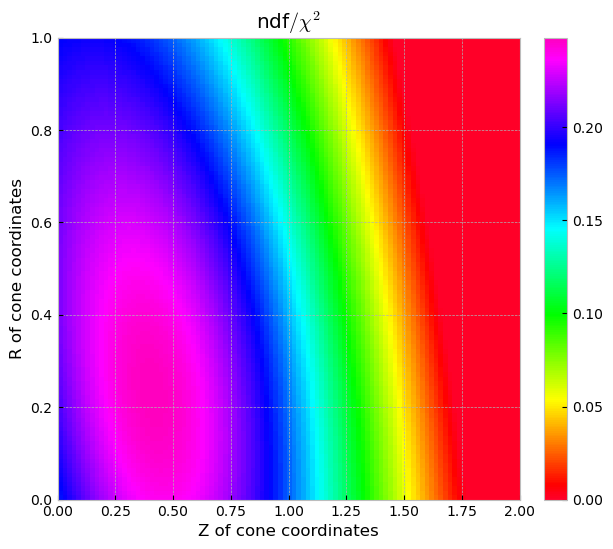

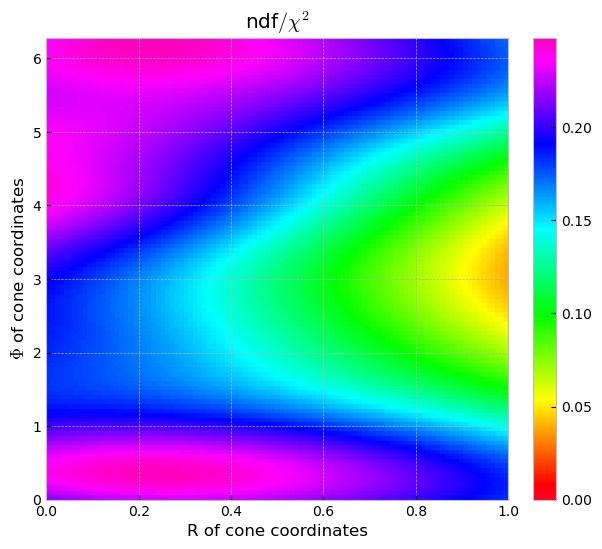

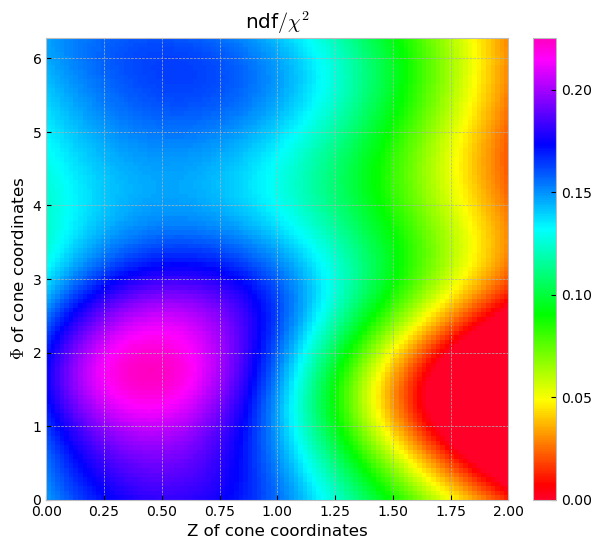

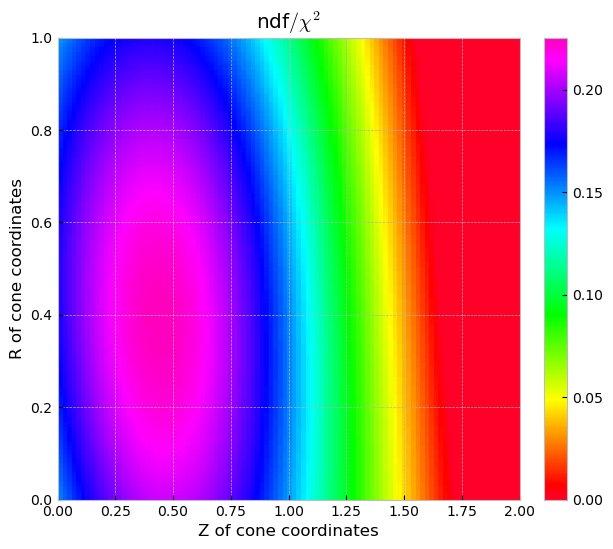

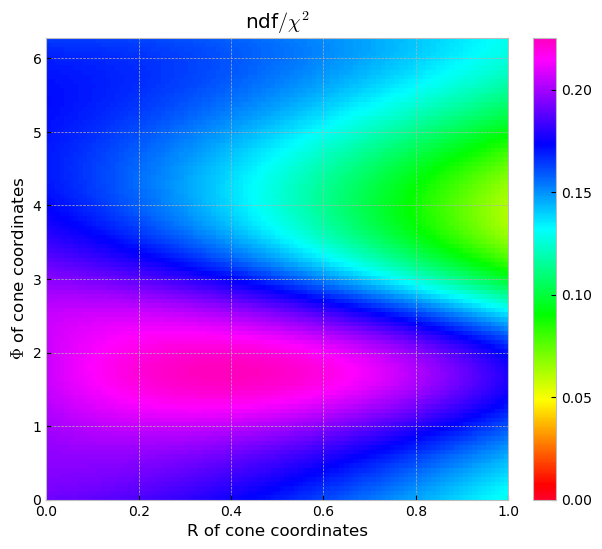

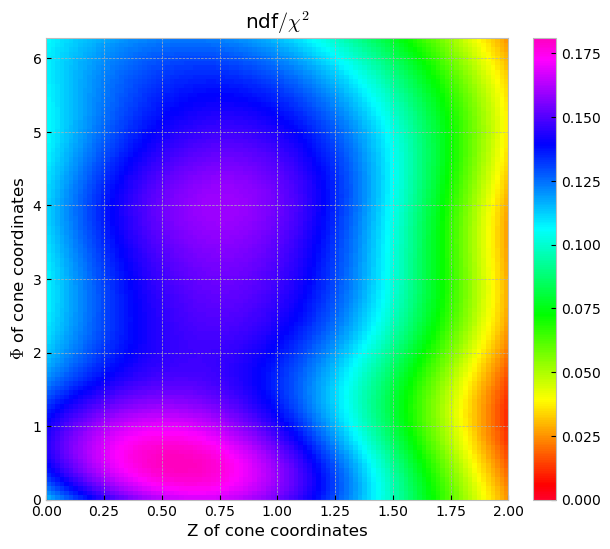

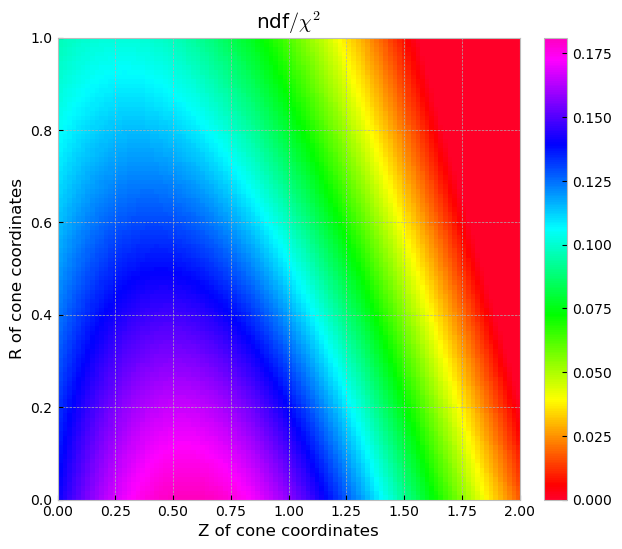

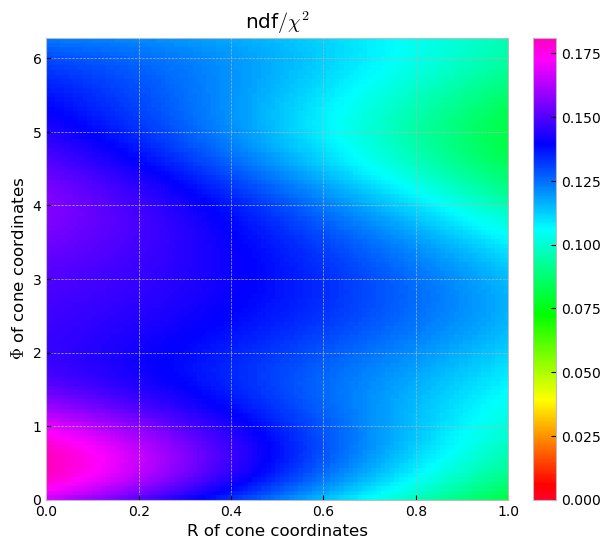

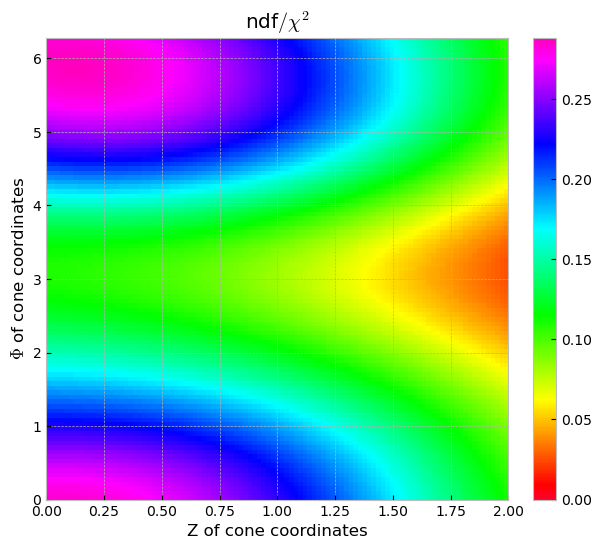

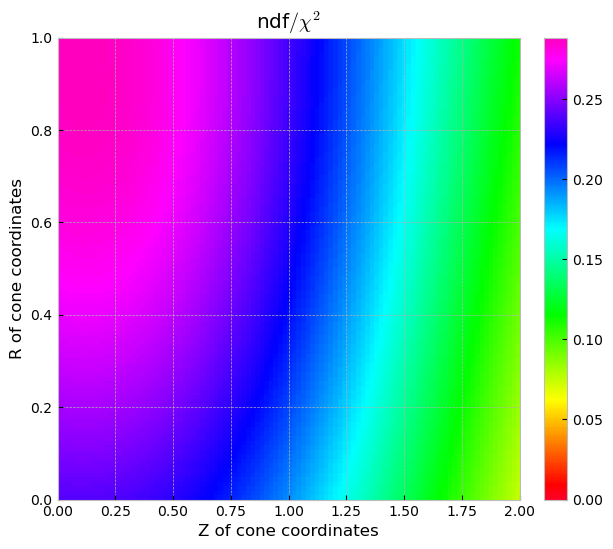

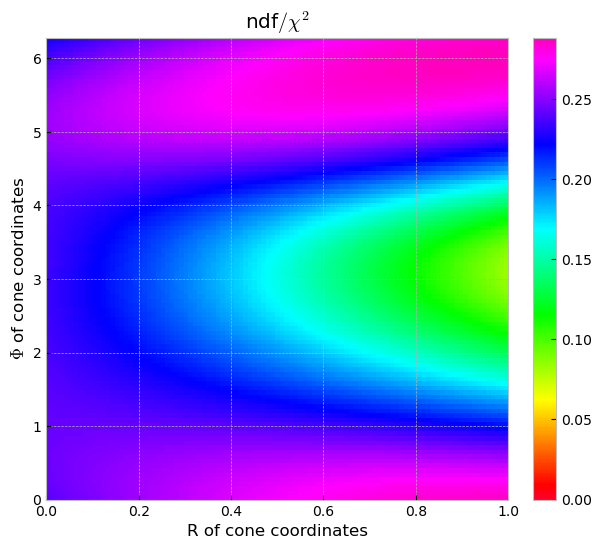

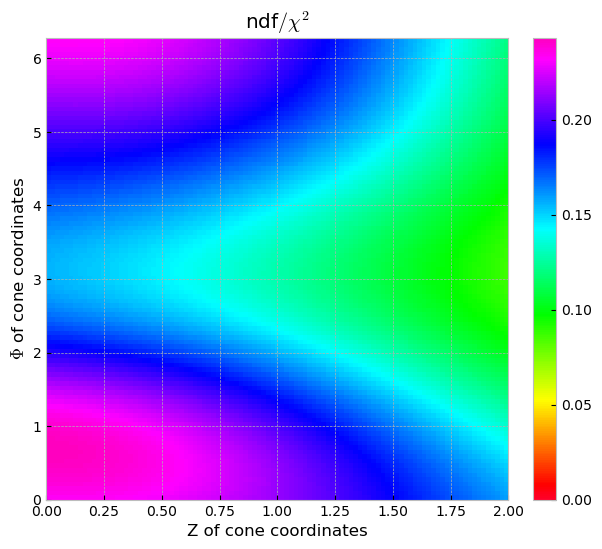

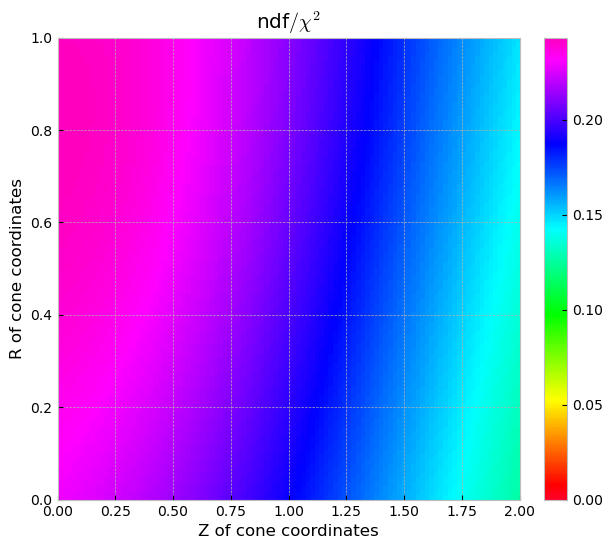

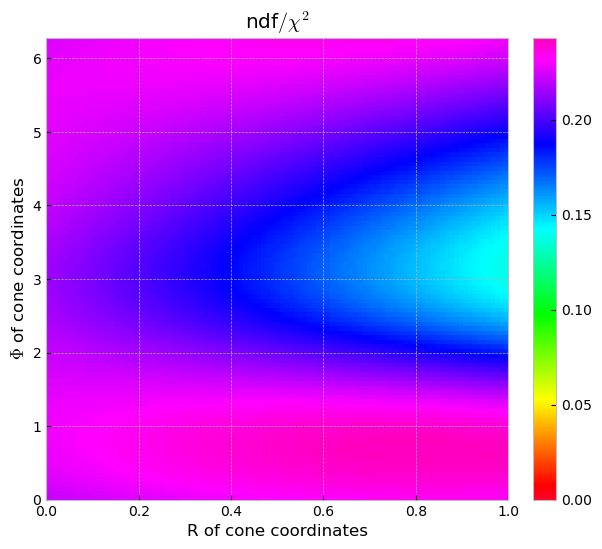

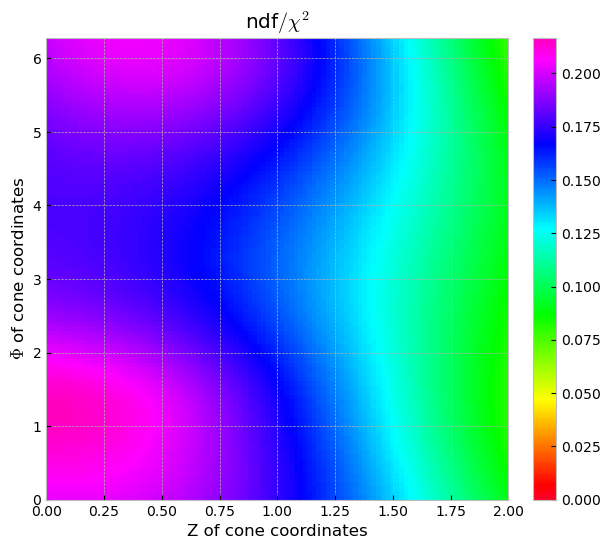

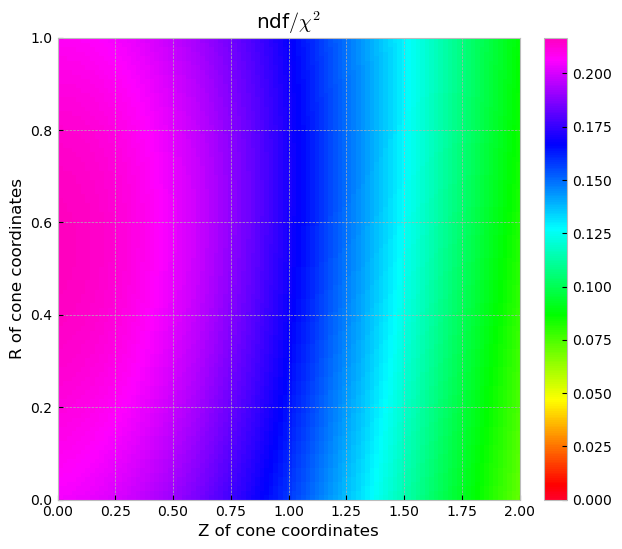

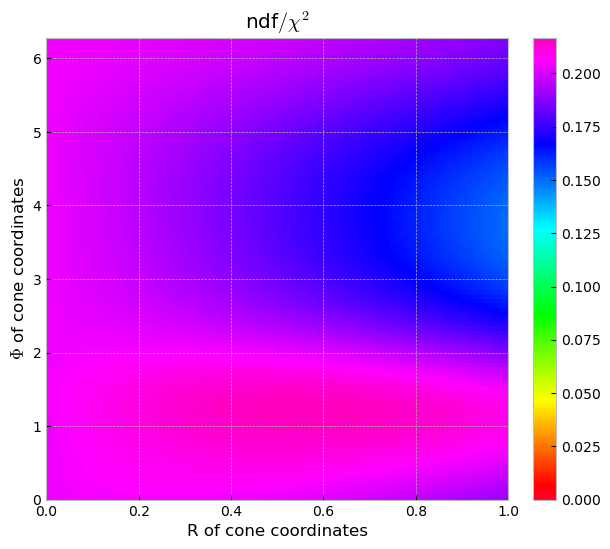

In [17]:
for HIST_INDEX in range(12):
    allHistsMC = []

    c_sorted, train_x_sorted, predictive_mean = fit_bo(HIST_INDEX)
    predictive_mean_2 = predictive_mean - predictive_mean.min()

    #interact(f, x=FloatSlider(description=axis_titles[0], min=0.0, max=1.0, step=0.01, value=train_x_sorted[-1][0], layout=Layout(width='500px')))
    f(train_x_sorted[-1][0])
    plt.savefig("chi2_bestR_" + str(HIST_INDEX) + ".png")
    #interact(g, x=FloatSlider(description=axis_titles[1], min=0.0, max=2*math.pi, step=0.01, value=train_x_sorted[-1][1], layout=Layout(width='500px')))
    g(train_x_sorted[-1][1])
    plt.savefig("chi2_bestPhi_" + str(HIST_INDEX) + ".png")
    #interact(h, x=FloatSlider(description=axis_titles[2], min=0.0, max=2, step=0.01, value=train_x_sorted[-1][2], layout=Layout(width='500px')))
    h(train_x_sorted[-1][2])
    plt.savefig("chi2_bestZ_" + str(HIST_INDEX) + ".png")

    bestIndex = int(c_sorted[-1][0].item())
    can1, hdiff1, py1 = plotComparison(allHistsMC[bestIndex], histsData[0][HIST_INDEX])
    can1.SaveAs("comparison_bestIndex_" + str(HIST_INDEX) + ".gif")

    worstIndex = int(c_sorted[0][0].item())
    can2, hdiff2, py2 = plotComparison(allHistsMC[worstIndex], histsData[0][HIST_INDEX])
    can2.SaveAs("comparison_worstIndex_" + str(HIST_INDEX) + ".gif")

    all = all_lambdas(xs)
    cov_lambda = np.cov(all, rowvar=False, aweights=predictive_mean_2)
    sgn_lambda = 1.0*(cov_lambda > 0) + -1.0*(cov_lambda < 0)

    np.multiply(
        sgn_lambda, np.sqrt(
            np.multiply(
                sgn_lambda, cov_lambda
            )
        )
    )
    print("Final result:")
    print("lambdas = ", c_sorted[-1][1:4])
    print("covariance matrix: \n", cov_lambda)